# Pre-process

## Package & Datasets loading

In [11]:
import pandas as pd
import numpy as np
import re
import stanza
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter

In [12]:
nltk.download('punkt')  
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/hao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/hao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/hao/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/hao/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [13]:
# stanza.download('en')
# nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment', tokenize_no_ssplit=True)

In [14]:
df = pd.read_csv('../../Final_Datasets/TA_combined_df_City_tourism_type_VADER_final_Stanza.csv')
df

,Hotel_locID,Hotel_geoID_x,Review_id,Review_Date,Date_of_stay,Reviewer_Contributions,Reviewer_helpful_vote,Review_Rating,Trip_type,Review_helpful_votes,...,Resaurant_count,Attractions_count,Hotel_styles,Popular_mentions,WordCount,Title,Review,Compound_Score,Unreliable,Stanza_Score
0,23448880,60763,916928494,Sep 16,September 2023,0,0,1,Traveled on business,1,...,348.0,100.0,['Business'],"['front desk', 'landmark view', 'city view roo...",66,Unfriendly staff and dirty,I travel a lot - and I am in general very flex...,-0.4095,0,0
1,23448880,60763,828890910,Feb 2022,February 2022,45,26,5,NaN,8,...,348.0,100.0,['Business'],"['front desk', 'landmark view', 'city view roo...",115,Perfect for Us,We recently chose Motto for an overnight in NY...,0.9903,0,2
2,23448880,60763,915189618,Sep 6,September 2023,0,0,3,Traveled on business,0,...,348.0,100.0,['Business'],"['front desk', 'landmark view', 'city view roo...",99,Not satisfied with the overall experience,The rooms are two small for the price that you...,-0.0121,0,0
3,23448880,60763,915010751,Sep 5,September 2023,68,88,5,Traveled with family,1,...,348.0,100.0,['Business'],"['front desk', 'landmark view', 'city view roo...",152,Magnificent Motto - fantastic staff,I have just returned home after a five day sta...,0.9746,0,2
4,23448880,60763,914794870,Sep 4,August 2023,179,68,5,Traveled solo,0,...,348.0,100.0,['Business'],"['front desk', 'landmark view', 'city view roo...",201,Worthy of a 5-star rating!,I did not believe the overwhelming 5-star revi...,0.9949,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65977,12841013,35805,536016764,Oct 2017,October 2017,0,0,4,Traveled solo,0,...,209.0,90.0,[],[],107,Great cost benefit,I stayed in the loop suites from 10/19/17 to 1...,0.9891,0,2
65978,12841013,35805,535664344,Oct 2017,October 2017,0,0,5,Traveled solo,0,...,209.0,90.0,[],[],43,AWESOME,I enjoy my stay! Very nice and very clean and ...,0.9703,0,2
65979,12841013,35805,535094403,Oct 2017,January 2017,0,0,5,Traveled solo,0,...,209.0,90.0,[],[],46,"Very good hotel, highly recommended",I've stayed in this apartment hotel in January...,0.7639,0,2
65980,12841013,35805,531949578,Oct 2017,May 2017,0,0,1,Traveled as a couple,0,...,209.0,90.0,[],[],158,Shocking,"We booked an apartment for 4 people, 2 couples...",-0.5707,0,0


In [15]:
df['Hotel_locID'].nunique()

704

## Data Overview & Labeling

In [16]:
# VADER
def calculate_compound_score(review):
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(review)['compound']

# Unreliable tag
def calculate_unreliable(row):
    compound_score = row['Compound_Score']
    rating = row['Review_Rating']
    
    if (compound_score < -0.49 and rating >= 3):
        return 1
    else:
        return 0

# Stanza
# def analyze_sentiment(text):
#   doc = nlp(text)
#   sentiments = [sentence.sentiment for sentence in doc.sentences]
  
#   compound_score = sentiments[0]
#   return compound_score

# Stanza x iterations
def analyze_sentiment(text):
    compound_scores = []
    num_iterations=11
    for _ in range(num_iterations):
        doc = nlp(text)
        sentiments = [sentence.sentiment for sentence in doc.sentences]
        compound_scores.append(sentiments[0])
    
    most_common_sentiment = Counter(compound_scores).most_common(1)
    # print(compound_scores)
    
    return most_common_sentiment[0][0]

# Stanza Unreliable tag
def calculate_unreliable_stanza(row):
    stanza_score = row['Stanza_Score']
    rating = row['Review_Rating']
    
    if (stanza_score == 2 and rating < 3) or (stanza_score == 0 and rating >= 3):
        return 1
    else:
        return 0

In [17]:
df['Unreliable'] = df.apply(calculate_unreliable, axis=1)
print(df['Unreliable'].value_counts())

Unreliable
0    64966
1     1016
Name: count, dtype: int64


In [18]:
# df['Stanza_Score'] = df['Review'].apply(analyze_sentiment)

In [19]:
# Unreliable reviews example
unreliable_reviews = df[df['Unreliable'] == 1]['Review']
unreliable_reviews.head(10)

133    Nice central location in Time Square with Pool...
209    I was supposed to stay here the weekend of the...
211    No service at all. Good location. No recogniti...
265    Anthony Lydia and the front desk agents are aw...
518    The room is too smaller for the high price, an...
548    Clogged sink would not drain. I appreciated th...
609    The charge for holding baggage while waiting f...
652    just ok - not pleased with shower (very weird ...
659    Title says it all. Better places to stay. Desk...
947    The hotel itself seems a little dated on the i...
Name: Review, dtype: object

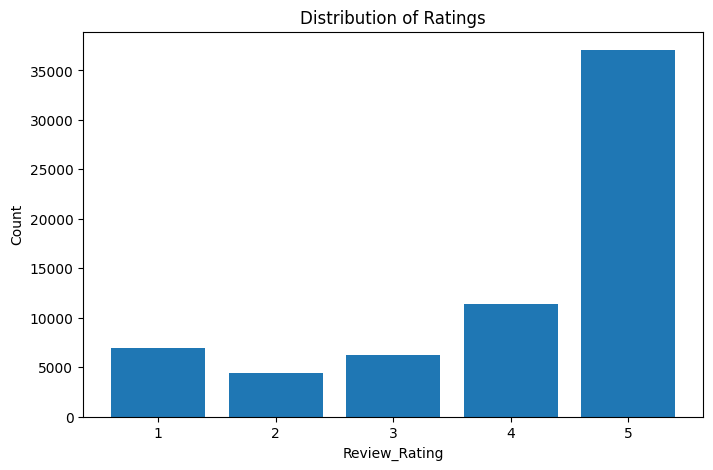

In [20]:
# Reviews rating distributions
rating_counts = df['Review_Rating'].value_counts()
rating_counts = rating_counts.sort_index()
plt.figure(figsize=(8, 5))  # size
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Review_Rating')  
plt.ylabel('Count')  
plt.title('Distribution of Ratings')  
plt.show()

## Function

In [21]:
def decontracting(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'bout", "about", text)
    text = re.sub(r"\'til", "until", text)
    return text

stopwords_list = stopwords.words('english')
def remove_stopwords(tokens):
    texts = [i for i in tokens if i not in stopwords_list]
    return texts


def lemmatization(tokens):
  lemmatizer = WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
  return lemmatized_tokens


def word_preprocess(df, column_name):
  #lowercase
  df[column_name] = df[column_name].apply(lambda x: str(x).lower())

  #decontracting
  df[column_name] = df[column_name].apply(decontracting)

  #remove tags, punctuations, numbers
  df[column_name] = df[column_name].apply(lambda x: re.sub('[^a-zA-Z!]', ' ', x))

  #tokenization
  import nltk
  nltk.download('punkt')
  df[column_name] = df[column_name].apply(lambda x: nltk.word_tokenize(x))

  #remove stopwords
  df[column_name] = df[column_name].apply(remove_stopwords)
  return df

## Text Preprocess

In [22]:
text_preprocessed_df = word_preprocess(df,'Review')

[nltk_data] Downloading package punkt to /home/hao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
text_preprocessed_df['Review']

0        [travel, lot, general, flexible, easy, hotels,...
1        [recently, chose, motto, overnight, nyc, glad,...
2        [rooms, two, small, price, pay, better, hotel,...
3        [returned, home, five, day, stay, new, york, w...
4        [believe, overwhelming, star, reviews, propert...
                               ...                        
65977    [stayed, loop, suites, found, valid, !, arrive...
65978    [enjoy, stay, !, nice, clean, good, looking, a...
65979    [stayed, apartment, hotel, january, studio, cl...
65980    [booked, apartment, people, couples, arrived, ...
65981    [sorry, english, write, everyone, understand, ...
Name: Review, Length: 65982, dtype: object

In [28]:
# delete nan row
text_preprocessed_df = text_preprocessed_df.dropna(subset=['Hotel_star', 'Review_Rating', 'Review', 'Reviewer_Contributions'])

In [29]:
text_preprocessed_df['Hotel_locID'].nunique()

620

In [35]:
text_preprocessed_df['Review_Rating'].mean()

3.9918591822406473

In [34]:
rating_counts = text_preprocessed_df['Review_Rating'].value_counts()
rating_proportions = text_preprocessed_df['Review_Rating'].value_counts(normalize=True)

# 打印計數和比例
print("Rating counts:\n", rating_counts)
print("Rating proportions:\n", rating_proportions)

Rating counts:
 Review_Rating
5    33033
4    10399
1     6513
3     5773
2     4104
Name: count, dtype: int64
Rating proportions:
 Review_Rating
5    0.552188
4    0.173832
1    0.108873
3    0.096503
2    0.068604
Name: proportion, dtype: float64


## Split datasets to sub-datasets

In [30]:
text_preprocessed_df

,Hotel_locID,Hotel_geoID_x,Review_id,Review_Date,Date_of_stay,Reviewer_Contributions,Reviewer_helpful_vote,Review_Rating,Trip_type,Review_helpful_votes,...,Resaurant_count,Attractions_count,Hotel_styles,Popular_mentions,WordCount,Title,Review,Compound_Score,Unreliable,Stanza_Score
0,23448880,60763,916928494,Sep 16,September 2023,0,0,1,Traveled on business,1,...,348.0,100.0,['Business'],"['front desk', 'landmark view', 'city view roo...",66,Unfriendly staff and dirty,"[travel, lot, general, flexible, easy, hotels,...",-0.4095,0,0
1,23448880,60763,828890910,Feb 2022,February 2022,45,26,5,NaN,8,...,348.0,100.0,['Business'],"['front desk', 'landmark view', 'city view roo...",115,Perfect for Us,"[recently, chose, motto, overnight, nyc, glad,...",0.9903,0,2
2,23448880,60763,915189618,Sep 6,September 2023,0,0,3,Traveled on business,0,...,348.0,100.0,['Business'],"['front desk', 'landmark view', 'city view roo...",99,Not satisfied with the overall experience,"[rooms, two, small, price, pay, better, hotel,...",-0.0121,0,0
3,23448880,60763,915010751,Sep 5,September 2023,68,88,5,Traveled with family,1,...,348.0,100.0,['Business'],"['front desk', 'landmark view', 'city view roo...",152,Magnificent Motto - fantastic staff,"[returned, home, five, day, stay, new, york, w...",0.9746,0,2
4,23448880,60763,914794870,Sep 4,August 2023,179,68,5,Traveled solo,0,...,348.0,100.0,['Business'],"['front desk', 'landmark view', 'city view roo...",201,Worthy of a 5-star rating!,"[believe, overwhelming, star, reviews, propert...",0.9949,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65954,290675,35805,17172887,Jun 2008,June 2008,0,2,4,Traveled with family,0,...,NaN,NaN,[],[],78,Loved the Amber Inn,"[loved, staying, amber, inn, !, !, !, budget, ...",0.9112,0,2
65955,290675,35805,8498082,Aug 2007,August 2007,8,9,5,NaN,0,...,NaN,NaN,[],[],48,Cannot get any better for the price,"[hotel, would, recommend, anyone, staff, frien...",0.9485,0,2
65956,290675,35805,6916950,Mar 2007,March 2007,0,7,1,Traveled with family,0,...,NaN,NaN,[],[],512,Disgusted,"[family, got, room, amber, inn, room, suite, q...",-0.9605,0,0
65957,290675,35805,6898967,Feb 2007,March 2007,0,0,5,Traveled on business,0,...,NaN,NaN,[],[],64,Wow! What a great place for the price!,"[enjoyed, stay, amber, inn, near, southside, d...",0.9601,0,2


In [17]:
def contributions_range(value):
    if value <= 5:
        return 1
    else:
        return 2
    
def hotel_star_range(value):
    if value <= 2.0:
        return 1
    elif value >= 2.5 and value <= 3.0:
        return 1
    elif value >= 3.5 and value <= 4.0:
        return 2
    else:
        return 2

In [18]:
# create new columns
text_preprocessed_df['Reviewer_Contributions_range'] = text_preprocessed_df['Reviewer_Contributions'].apply(contributions_range)
text_preprocessed_df['Hotel_star_range'] = text_preprocessed_df['Hotel_star'].apply(hotel_star_range)
text_preprocessed_df

/tmp/ipykernel_3137191/1093502009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_preprocessed_df['Reviewer_Contributions_range'] = text_preprocessed_df['Reviewer_Contributions'].apply(contributions_range)
/tmp/ipykernel_3137191/1093502009.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_preprocessed_df['Hotel_star_range'] = text_preprocessed_df['Hotel_star'].apply(hotel_star_range)


,Hotel_locID,Hotel_geoID_x,Review_id,Review_Date,Date_of_stay,Reviewer_Contributions,Reviewer_helpful_vote,Review_Rating,Trip_type,Review_helpful_votes,...,Hotel_styles,Popular_mentions,WordCount,Title,Review,Compound_Score,Unreliable,Stanza_Score,Reviewer_Contributions_range,Hotel_star_range
0,23448880,60763,916928494,Sep 16,September 2023,0,0,1,Traveled on business,1,...,['Business'],"['front desk', 'landmark view', 'city view roo...",66,Unfriendly staff and dirty,"[travel, lot, general, flexible, easy, hotels,...",-0.4095,0,0,1,2
1,23448880,60763,828890910,Feb 2022,February 2022,45,26,5,NaN,8,...,['Business'],"['front desk', 'landmark view', 'city view roo...",115,Perfect for Us,"[recently, chose, motto, overnight, nyc, glad,...",0.9903,0,2,2,2
2,23448880,60763,915189618,Sep 6,September 2023,0,0,3,Traveled on business,0,...,['Business'],"['front desk', 'landmark view', 'city view roo...",99,Not satisfied with the overall experience,"[rooms, two, small, price, pay, better, hotel,...",-0.0121,0,0,1,2
3,23448880,60763,915010751,Sep 5,September 2023,68,88,5,Traveled with family,1,...,['Business'],"['front desk', 'landmark view', 'city view roo...",152,Magnificent Motto - fantastic staff,"[returned, home, five, day, stay, new, york, w...",0.9746,0,2,2,2
4,23448880,60763,914794870,Sep 4,August 2023,179,68,5,Traveled solo,0,...,['Business'],"['front desk', 'landmark view', 'city view roo...",201,Worthy of a 5-star rating!,"[believe, overwhelming, star, reviews, propert...",0.9949,0,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65954,290675,35805,17172887,Jun 2008,June 2008,0,2,4,Traveled with family,0,...,[],[],78,Loved the Amber Inn,"[loved, staying, amber, inn, !, !, !, budget, ...",0.9112,0,2,1,1
65955,290675,35805,8498082,Aug 2007,August 2007,8,9,5,NaN,0,...,[],[],48,Cannot get any better for the price,"[hotel, would, recommend, anyone, staff, frien...",0.9485,0,2,2,1
65956,290675,35805,6916950,Mar 2007,March 2007,0,7,1,Traveled with family,0,...,[],[],512,Disgusted,"[family, got, room, amber, inn, room, suite, q...",-0.9605,0,0,1,1
65957,290675,35805,6898967,Feb 2007,March 2007,0,0,5,Traveled on business,0,...,[],[],64,Wow! What a great place for the price!,"[enjoyed, stay, amber, inn, near, southside, d...",0.9601,0,2,1,1


In [19]:
# Split 4 sub-datasets
LCLS = text_preprocessed_df[(text_preprocessed_df['Reviewer_Contributions_range'] == 1) & (text_preprocessed_df['Hotel_star_range'] == 1)]
LCHS = text_preprocessed_df[(text_preprocessed_df['Reviewer_Contributions_range'] == 1) & (text_preprocessed_df['Hotel_star_range'] == 2)]
HCLS = text_preprocessed_df[(text_preprocessed_df['Reviewer_Contributions_range'] == 2) & (text_preprocessed_df['Hotel_star_range'] == 1)]
HCHS = text_preprocessed_df[(text_preprocessed_df['Reviewer_Contributions_range'] == 2) & (text_preprocessed_df['Hotel_star_range'] == 2)]


In [20]:
# split unreliable reviews
LCLS_unreliable = LCLS[LCLS['Unreliable'] == 1]
LCHS_unreliable = LCHS[LCHS['Unreliable'] == 1]
HCLS_unreliable = HCLS[HCLS['Unreliable'] == 1]
HCHS_unreliable = HCHS[HCHS['Unreliable'] == 1]

In [21]:
# split reliable reviews
LCLS_reliable = LCLS[LCLS['Unreliable'] == 0]
LCHS_reliable = LCHS[LCHS['Unreliable'] == 0]
HCLS_reliable = HCLS[HCLS['Unreliable'] == 0]
HCHS_reliable = HCHS[HCHS['Unreliable'] == 0]

In [22]:
# split subset
selected_columns = ['Review', 'Review_Rating']
LCLS_text = LCLS_reliable.loc[:, selected_columns]
LCHS_text = LCHS_reliable.loc[:, selected_columns]
HCLS_text = HCLS_reliable.loc[:, selected_columns]
HCHS_text = HCHS_reliable.loc[:, selected_columns]

# reset index
LCLS_text.reset_index(drop=True, inplace=True)
LCHS_text.reset_index(drop=True, inplace=True)
HCLS_text.reset_index(drop=True, inplace=True)
HCHS_text.reset_index(drop=True, inplace=True)

In [23]:
LCLS_text['Review'] = [' '.join(text) for text in LCLS_text['Review']]
LCHS_text['Review'] = [' '.join(text) for text in LCHS_text['Review']]
HCLS_text['Review'] = [' '.join(text) for text in HCLS_text['Review']]
HCHS_text['Review'] = [' '.join(text) for text in HCHS_text['Review']]

# Split sub-datasets to X & Y, Training and Testing set

In [24]:
LCLS_X = LCLS_text['Review']
LCLS_y = LCLS_text['Review_Rating']

LCHS_X = LCHS_text['Review']
LCHS_y = LCHS_text['Review_Rating']

HCLS_X = HCLS_text['Review']
HCLS_y = HCLS_text['Review_Rating']

HCHS_X = HCHS_text['Review']
HCHS_y = HCHS_text['Review_Rating']

LCLS_X_train, LCLS_X_test, LCLS_y_train, LCLS_y_test = train_test_split(LCLS_X, LCLS_y, test_size=0.2, random_state=88)
LCHS_X_train, LCHS_X_test, LCHS_y_train, LCHS_y_test = train_test_split(LCHS_X, LCHS_y, test_size=0.2, random_state=88)
HCLS_X_train, HCLS_X_test, HCLS_y_train, HCLS_y_test = train_test_split(HCLS_X, HCLS_y, test_size=0.2, random_state=88)
HCHS_X_train, HCHS_X_test, HCHS_y_train, HCHS_y_test = train_test_split(HCHS_X, HCHS_y, test_size=0.2, random_state=88)

In [25]:
LCLS_X_train

10068    know great stay suite constant cannabis odor c...
8028     stayed five nights chose proximity broadway wa...
12388    enjoyed stay valet parking could better check ...
8983     experience hotel never book another hotel onli...
10036    love hotel ! place always clean staff awesome ...
                               ...                        
8554     room clean cleaned daily basis despite room le...
2481     checked hotel around pm greeted friendly staff...
4047     basic hotel underwhelming hilton property lobb...
6432     first trip hotel since start pandemic stayed h...
10200    bad experience hotel stayed hotel one night bo...
Name: Review, Length: 11072, dtype: object

In [26]:
LCLS_y_train

10068    2
8028     3
12388    4
8983     1
10036    5
        ..
8554     5
2481     4
4047     3
6432     1
10200    1
Name: Review_Rating, Length: 11072, dtype: int64

# Feature extraction

## Initial variable

In [27]:
# LCLS 
LCLS_X_train_bow_df = None
LCLS_X_train_tfidf_df = None
LCLS_X_train_d2v = None
LCLS_X_train_glove = None
LCLS_X_train_bert = None
LCLS_X_test_bow_df = None
LCLS_X_test_tfidf_df = None
LCLS_X_test_d2v = None
LCLS_X_test_glove = None
LCLS_X_test_bert = None

# LCHS
LCHS_X_train_bow_df = None
LCHS_X_train_tfidf_df = None
LCHS_X_train_d2v = None
LCHS_X_train_glove = None
LCHS_X_train_bert = None
LCHS_X_test_bow_df = None
LCHS_X_test_tfidf_df = None
LCHS_X_test_d2v = None
LCHS_X_test_glove = None
LCHS_X_test_bert = None

# HCLS
HCLS_X_train_bow_df = None
HCLS_X_train_tfidf_df = None
HCLS_X_train_d2v = None
HCLS_X_train_glove = None
HCLS_X_train_bert = None
HCLS_X_test_bow_df = None
HCLS_X_test_tfidf_df = None
HCLS_X_test_d2v = None
HCLS_X_test_glove = None
HCLS_X_test_bert = None

# HCHS
HCHS_X_train_bow_df = None
HCHS_X_train_tfidf_df = None
HCHS_X_train_d2v = None
HCHS_X_train_glove = None
HCHS_X_train_bert = None
HCHS_X_test_bow_df = None
HCHS_X_test_tfidf_df = None
HCHS_X_test_d2v = None
HCHS_X_test_glove = None
HCHS_X_test_bert = None


## BOW

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

def generate_bow_train(X_train, max_features=1000):
    vectorizer = CountVectorizer(max_features=max_features)
    bow_vectors = vectorizer.fit_transform(X_train)
    bow_df = pd.DataFrame(bow_vectors.toarray(), columns=vectorizer.get_feature_names_out())
    
    return bow_df, vectorizer

def generate_bow_test(X_test, vectorizer):
    bow_vectors = vectorizer.transform(X_test)
    bow_df = pd.DataFrame(bow_vectors.toarray(), columns=vectorizer.get_feature_names_out())
    
    return bow_df

In [29]:
LCLS_X_train_bow_df, LCLS_vectorizer = generate_bow_train(LCLS_X_train)
LCHS_X_train_bow_df, LCHS_vectorizer = generate_bow_train(LCHS_X_train)
HCLS_X_train_bow_df, HCLS_vectorizer = generate_bow_train(HCLS_X_train)
HCHS_X_train_bow_df, HCHS_vectorizer = generate_bow_train(HCHS_X_train)


### Testing set

In [30]:
LCLS_X_test_bow_df = generate_bow_test(LCLS_X_test, LCLS_vectorizer)
LCHS_X_test_bow_df = generate_bow_test(LCHS_X_test, LCHS_vectorizer)
HCLS_X_test_bow_df = generate_bow_test(HCLS_X_test, HCLS_vectorizer)
HCHS_X_test_bow_df = generate_bow_test(HCHS_X_test, HCHS_vectorizer)

## TF-IDF

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

def generate_tfidf_train(X_train, stop_words='english', max_features=1000, max_df=0.9):
    tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=max_features, max_df=max_df)
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    tfidf_df = pd.DataFrame(X_train_tfidf, columns=feature_names)
    
    return tfidf_df, tfidf_vectorizer

def generate_tfidf_test(X_test, tfidf_vectorizer):
    X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    tfidf_df = pd.DataFrame(X_test_tfidf, columns=feature_names)
    
    return tfidf_df

In [32]:
LCLS_X_train_tfidf_df, tfidf_vectorizer_LCLS = generate_tfidf_train(LCLS_X_train)
LCHS_X_train_tfidf_df, tfidf_vectorizer_LCHS = generate_tfidf_train(LCHS_X_train)
HCLS_X_train_tfidf_df, tfidf_vectorizer_HCLS = generate_tfidf_train(HCLS_X_train)
HCHS_X_train_tfidf_df, tfidf_vectorizer_HCHS = generate_tfidf_train(HCHS_X_train)

### Testing set

In [33]:
LCLS_X_test_tfidf_df = generate_tfidf_test(LCLS_X_test, tfidf_vectorizer_LCLS)
LCHS_X_test_tfidf_df = generate_tfidf_test(LCHS_X_test, tfidf_vectorizer_LCHS)
HCLS_X_test_tfidf_df = generate_tfidf_test(HCLS_X_test, tfidf_vectorizer_HCLS)
HCHS_X_test_tfidf_df = generate_tfidf_test(HCHS_X_test, tfidf_vectorizer_HCHS)

## Doc2Vec

In [32]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def train_doc2vec_model(X_train, min_count=5, workers=8, epochs=40, vector_size=100):
    tagged_docs = [TaggedDocument(doc.split(' '), [i]) for i, doc in enumerate(X_train)]
    model = Doc2Vec(min_count=min_count, workers=workers, epochs=epochs, vector_size=vector_size)
    model.build_vocab(tagged_docs)
    model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.epochs)
    
    return model

In [33]:
# Get different datasets of Doc2vec
LCLS_model = train_doc2vec_model(LCLS_X_train)
LCHS_model = train_doc2vec_model(LCHS_X_train)
HCLS_model = train_doc2vec_model(HCLS_X_train)
HCHS_model = train_doc2vec_model(HCHS_X_train)

In [34]:
LCLS_X_train_d2v = np.array([LCLS_model.infer_vector((doc.split(' '))) for doc in LCLS_X_train])
LCHS_X_train_d2v = np.array([LCHS_model.infer_vector((doc.split(' '))) for doc in LCHS_X_train])
HCLS_X_train_d2v = np.array([HCLS_model.infer_vector((doc.split(' '))) for doc in HCLS_X_train])
HCHS_X_train_d2v = np.array([HCHS_model.infer_vector((doc.split(' '))) for doc in HCHS_X_train])

In [35]:
pd.DataFrame(LCLS_X_train_d2v)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.420038,-0.137814,-0.672931,-0.048338,0.257554,-0.508485,0.067258,0.050535,-0.125036,-0.243427,...,0.731708,-1.419739,0.893972,0.654294,0.456221,-0.031559,-0.215463,0.393943,1.197819,-0.150579
1,-0.577724,1.474236,0.830702,0.333341,0.126601,-1.202635,0.264417,1.231556,-0.321903,-0.325401,...,0.650024,-0.421409,-0.705633,0.957478,0.314797,-0.319810,0.824032,0.884045,-0.049953,-0.465094
2,-0.987011,0.013703,-0.789353,-0.669415,0.694016,-0.062259,0.265854,-0.371863,-0.014208,-0.999901,...,0.112341,-0.000965,0.005798,0.385954,-0.315357,-0.451605,-0.544369,-0.053989,0.982577,-0.475638
3,0.635276,-1.040346,-0.511011,-1.824096,1.228252,-0.977466,-1.414186,1.829410,0.169014,-1.277872,...,0.376195,-0.017889,-0.898941,-0.449298,-0.208367,-0.442591,0.232864,-0.134150,0.486710,1.391931
4,-0.492631,-0.159090,-0.005658,-0.331564,-0.498393,-0.824741,0.216908,0.190781,-0.513620,-0.255126,...,0.159996,0.724780,0.194055,-0.660124,0.269931,-0.030248,0.040479,-0.072980,0.257952,-0.706904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11067,0.389908,-0.404734,-0.593271,0.011259,-0.412428,-1.396813,0.182376,0.938383,-0.338154,-0.930071,...,0.584281,-0.082929,-0.095575,0.519181,-0.118784,-0.536948,-0.085290,1.278635,-0.127061,0.516150
11068,-0.486811,-0.229888,-0.561770,-0.661505,0.892058,-0.104794,0.796163,-0.082376,0.201466,0.368111,...,0.611810,0.578091,-0.431954,-0.289156,0.482916,-0.443217,0.237533,-0.244937,0.407013,0.010837
11069,-0.394486,-0.362818,0.582411,1.114725,-0.089040,-1.236607,-0.116099,0.098290,0.069796,0.287751,...,1.483697,-1.049001,-0.365073,-0.853555,0.309236,0.328871,-0.173823,-0.917142,0.466082,0.547539
11070,2.069112,0.305922,0.667674,-1.179331,0.505365,-2.290150,1.034250,1.413705,-0.049996,0.323823,...,1.278728,-0.689130,-1.646500,-0.284164,0.169555,-1.085622,-0.044825,-0.565876,0.197612,-0.386873


In [36]:
pd.DataFrame(LCHS_X_train_d2v)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.216706,0.223817,-0.106874,-0.324188,0.380044,-0.437628,0.113206,0.532690,-0.414732,-0.104914,...,0.779882,-0.004022,0.501277,0.080601,0.951948,-0.073410,-0.084550,-1.084819,0.005970,-0.367926
1,-0.142201,-0.435818,-0.272078,-0.129019,-0.124546,-0.444816,0.467958,-0.175551,-1.017065,-0.117898,...,0.664222,0.055104,0.119319,-0.216775,0.444023,0.052784,-0.370323,0.725307,-0.037196,-0.088772
2,-0.500656,0.224947,-0.125162,-0.359986,-0.847863,-0.121992,0.905975,1.446065,0.547100,0.681747,...,-0.371687,0.237080,-0.510632,-0.587210,0.779872,0.589508,-0.980342,-0.202556,0.232966,0.663150
3,0.099435,0.133633,-0.286403,0.245133,-0.261736,-1.340672,0.018592,0.496489,-0.186270,-0.168530,...,-0.123085,0.454885,0.327316,0.196841,0.487538,1.328191,0.321634,-0.306395,-0.526211,-0.095210
4,-1.130783,0.726551,0.861279,-0.645159,-0.099786,0.269916,-1.221502,0.920094,-0.804217,-0.098294,...,0.900295,-0.554117,0.634034,0.465180,0.742794,1.063203,-0.928083,-1.316365,-0.670474,-0.390120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14567,0.006562,-0.611649,-0.421685,-0.211747,0.139696,-1.192670,-0.396552,0.633216,0.165928,-0.239532,...,0.772884,0.393971,0.605217,-0.043556,0.389596,0.170203,-0.116788,-0.545702,-0.696273,-0.913728
14568,0.692786,0.235093,0.262632,0.059003,-0.425859,-0.240068,-0.131834,0.362551,0.023722,-0.032007,...,0.443371,0.043718,0.866661,0.561132,0.597910,0.352867,-0.209664,-0.277360,-0.190037,-0.309957
14569,0.391481,-0.454994,0.213327,0.328525,0.242123,-1.182839,0.177323,0.239746,-0.759456,0.102401,...,0.831659,0.057767,-0.138991,0.422612,-0.247114,-0.059798,-0.508456,-0.683477,-0.607758,-0.834476
14570,-0.600329,-0.686146,0.670569,0.162471,0.169063,-1.216501,0.100986,0.914042,-0.411185,0.343274,...,0.354638,-0.290390,0.023491,0.119475,0.949321,0.760663,-0.333074,-0.355766,-0.472101,-0.489957


In [37]:
pd.DataFrame(HCLS_X_train_d2v)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.392007,0.752417,1.461618,0.270634,0.891404,-1.632986,0.597718,0.655775,0.717645,-0.485144,...,0.438150,-1.368687,-0.283438,0.066981,1.486599,-0.067170,0.126210,0.484489,-0.201825,1.791172
1,-1.687063,0.627415,-0.649185,-0.878875,-0.230811,-1.201510,0.208998,0.854198,0.591216,0.215917,...,0.881964,0.325262,0.393809,1.172744,0.287069,-0.102608,0.457402,-0.766513,0.134360,0.681707
2,0.272540,-0.164613,0.299398,0.231375,0.194530,-1.637352,0.583118,0.557063,0.111100,-0.563522,...,-0.186097,0.523657,-0.270523,0.168853,0.497594,0.144691,0.072795,-0.172682,0.601113,0.273255
3,-1.465424,-0.052296,0.659472,0.319892,0.313177,0.493623,1.721766,1.023888,-0.126115,1.257494,...,0.851812,1.517964,0.169548,-0.077557,-0.338893,1.545166,2.268258,-0.345380,-0.830447,-0.606709
4,0.809303,0.343024,-1.160394,-0.248613,-0.131502,-1.496924,0.404667,0.679787,0.185052,0.205501,...,-0.049659,-0.672558,0.137203,0.260084,0.279790,0.534051,0.291067,-0.006575,0.911675,0.348043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11271,0.327967,0.466122,-0.281972,0.105390,-0.461453,-0.489183,1.357371,0.695672,-0.049690,-0.418467,...,0.505819,1.531771,-1.089780,0.734305,-0.301881,1.123509,0.183962,0.391598,-0.310543,0.326280
11272,0.455735,-0.102401,0.019555,-0.091397,0.367437,-0.721175,-0.045553,0.840044,-0.097941,-0.170277,...,1.092049,0.282818,-0.096078,0.301840,0.027986,0.028353,0.147972,-0.221167,-0.038595,0.067848
11273,-0.319371,-0.322931,-0.120763,-0.328996,0.876784,-0.551339,0.584249,0.736280,-0.139512,-0.135945,...,0.427068,0.465714,-0.023482,-0.253669,0.079769,0.236070,0.810938,0.037331,-0.621882,0.126756
11274,-0.055215,-0.868389,-0.065315,0.341400,0.620811,-0.447402,0.973733,1.689028,0.372779,-1.118641,...,-0.798032,-0.764446,-0.419705,0.296112,-0.594501,0.614508,-1.077608,-0.540341,-0.453600,1.317472


In [38]:
pd.DataFrame(HCHS_X_train_d2v)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.229743,-0.507023,-1.091584,-0.538226,-0.231148,-0.552054,-1.368170,0.792605,-1.424482,-0.770826,...,0.819414,-0.512064,0.935343,0.606937,0.804680,0.688379,-0.182540,-0.022279,0.213744,0.232666
1,-0.117973,0.014540,0.227047,0.141568,0.386593,-0.744884,-0.692092,0.584822,-1.111335,-0.539873,...,-0.754277,0.898372,0.145316,-0.502474,0.791059,0.334987,0.021284,-0.485388,0.632539,-0.895432
2,0.777472,0.320051,-0.128952,0.993159,-0.462185,-0.233549,0.214148,0.481494,-0.583282,0.575765,...,0.143715,1.100786,0.988390,-0.191273,-0.319355,-0.122885,-0.108874,-0.422521,-0.033063,-0.254429
3,0.143269,-0.412327,-0.629746,0.308937,-0.159793,-0.400257,0.187810,0.714197,-0.169617,0.465454,...,-0.009039,0.529298,-0.439653,-0.028287,0.505921,0.153040,0.052188,-0.338128,0.359595,0.087094
4,-0.281276,-0.870476,-0.565698,-0.587749,0.833893,-1.613593,-0.075133,0.545658,-0.283723,-0.023972,...,0.692993,1.561380,-0.405945,0.795915,0.988769,-0.446762,0.218249,-0.574484,-0.239763,-0.795572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10165,0.674814,0.629991,-0.338991,0.592412,-1.370955,-0.409500,-0.102310,1.008973,-0.393403,-0.556529,...,0.206276,0.447242,-0.048629,-0.257221,0.450534,-0.059016,0.463399,-0.270419,-0.051671,1.451404
10166,0.264380,0.520081,-0.072263,-0.164290,0.442769,0.079019,0.554374,0.265895,-0.351159,-0.484304,...,0.034517,0.970557,0.412740,0.307614,1.399695,0.619739,0.402508,0.293751,-0.276138,0.386618
10167,-1.198763,-0.060852,0.143378,-0.914587,0.092552,-0.672464,0.562730,0.607291,-1.311519,0.574180,...,-0.786396,0.937513,0.020408,0.739119,1.110414,-0.081913,0.544763,-0.176753,-0.040981,-0.589244
10168,-0.712850,0.503971,-0.308664,0.428874,1.525626,-0.718698,0.354906,-0.010260,0.428296,-0.610600,...,1.310773,1.887084,1.237084,-1.263300,0.212857,0.057205,0.863330,-0.582675,0.679375,-1.075885


### Testing set

In [39]:
LCLS_X_test_d2v = np.array([LCLS_model.infer_vector((doc.split(' '))) for doc in LCLS_X_test])
LCHS_X_test_d2v = np.array([LCHS_model.infer_vector((doc.split(' '))) for doc in LCHS_X_test])
HCLS_X_test_d2v = np.array([HCLS_model.infer_vector((doc.split(' '))) for doc in HCLS_X_test])
HCHS_X_test_d2v = np.array([HCHS_model.infer_vector((doc.split(' '))) for doc in HCHS_X_test])

## GloVe

In [126]:
glove_path = '../GloVe_wordvec/glove.6B.100d.txt'

# import GloVe word vectors into dictionary
embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [127]:
# define function to create embedding matrix
def glove_embedding(comment, embeddings_index = embeddings_index, dim=100):
    words = comment.split()
    vec = np.zeros(dim)
    count = 0
    for word in words:
        embedding_vector = embeddings_index.get(word) # get GloVe word vectors
        if embedding_vector is not None:
            vec += embedding_vector
            count += 1
    if count != 0:
        vec /= count
    return vec

In [128]:
# train
LCLS_X_train_glove = np.array([glove_embedding(comment) for comment in LCLS_X_train])
LCHS_X_train_glove = np.array([glove_embedding(comment) for comment in LCHS_X_train])
HCLS_X_train_glove = np.array([glove_embedding(comment) for comment in HCLS_X_train])
HCHS_X_train_glove = np.array([glove_embedding(comment) for comment in HCHS_X_train])

In [44]:
pd.DataFrame(LCLS_X_train_glove)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.023992,-0.039079,0.296264,-0.237071,-0.151624,0.340974,-0.066503,0.309266,0.085064,-0.064599,...,0.236503,0.015690,0.140292,-0.060600,-0.255384,0.082591,-0.006289,-0.009381,0.337734,0.138108
1,-0.170518,0.074603,0.238125,-0.102362,0.001733,0.168701,-0.132858,0.432343,-0.010722,0.022450,...,0.011282,-0.108942,0.071287,-0.174182,-0.568867,0.140666,-0.113348,0.002950,0.374100,0.192074
2,-0.093806,-0.060850,0.296436,-0.179451,-0.076238,0.169154,-0.136328,0.469972,0.290695,-0.014746,...,0.162560,-0.113817,0.327392,-0.156790,-0.364735,0.076559,-0.022164,0.058268,0.552769,0.123194
3,-0.065803,0.181605,0.270492,-0.207001,-0.128023,0.243699,-0.021704,0.350799,0.040657,-0.052574,...,0.101987,-0.142861,0.171897,-0.124271,-0.355647,-0.017630,-0.067118,-0.064801,0.424609,0.083366
4,-0.017846,0.218327,0.350826,-0.289497,-0.234915,0.188229,-0.186909,0.252001,-0.047220,-0.128190,...,0.052861,-0.152064,0.287734,0.098489,-0.552768,-0.017102,-0.160565,-0.188943,0.389988,0.338062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11067,-0.060565,0.237114,0.272883,-0.207138,-0.125995,0.170181,-0.074178,0.165311,-0.009205,-0.076757,...,0.048294,-0.074803,0.110280,-0.183655,-0.484453,0.004562,-0.042739,-0.114552,0.410044,0.215139
11068,-0.124657,0.101271,0.219382,-0.042047,-0.213371,0.072996,0.065513,0.383784,-0.161596,0.026596,...,0.281881,-0.091722,0.114590,-0.027783,-0.483824,0.136178,-0.088659,-0.035635,0.560823,0.141612
11069,-0.068153,0.123244,0.185302,-0.127660,-0.124014,0.292227,0.032201,0.365379,0.024816,-0.012145,...,0.106635,-0.116547,0.189137,0.008954,-0.432882,0.065838,-0.122937,-0.089474,0.472984,0.190128
11070,-0.050511,0.098430,0.239151,-0.125203,-0.084869,0.214339,0.015258,0.309809,0.020759,0.001958,...,0.187991,-0.002887,0.084901,-0.023960,-0.421153,0.020129,-0.021075,0.013633,0.326544,0.079239


In [45]:
pd.DataFrame(LCHS_X_train_glove)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.080562,0.350155,0.353519,-0.209341,-0.091900,0.176816,-0.193373,0.157371,-0.189842,-0.177141,...,0.076498,-0.057512,0.123696,-0.179928,-0.544104,-0.028180,-0.126459,-0.118252,0.243571,0.286030
1,-0.168344,0.221720,0.333379,-0.047032,-0.166015,0.199829,0.017165,0.490170,-0.126206,-0.147241,...,0.274026,-0.192581,0.404701,-0.053617,-0.483529,0.105168,-0.334020,-0.270180,0.432537,0.242779
2,-0.019711,0.110807,0.217262,-0.105622,-0.120749,0.192231,-0.137001,0.353184,0.000239,0.013066,...,0.131551,-0.134905,0.199084,-0.114710,-0.344654,0.086330,-0.141992,-0.026805,0.420935,0.145781
3,-0.187830,0.150085,0.381261,-0.201324,-0.098468,0.081530,-0.255859,0.142347,-0.002249,-0.147537,...,0.046568,-0.111711,0.138644,-0.070026,-0.360486,-0.018556,0.069945,-0.237633,0.212155,0.332749
4,-0.047349,0.236234,0.289707,-0.258953,-0.086739,0.276159,-0.008727,0.278054,-0.109882,-0.071229,...,0.074848,-0.067538,0.233041,0.025593,-0.424685,-0.095188,-0.105312,-0.126544,0.321676,0.170144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14567,0.090223,0.274576,0.263096,-0.414784,-0.151661,0.301076,0.020567,0.316897,-0.003454,-0.092710,...,0.243055,-0.100994,0.384390,0.086537,-0.462172,-0.217686,-0.194873,-0.050864,0.367442,0.287788
14568,-0.069399,0.008654,0.247225,-0.215953,0.148783,0.064829,-0.180638,0.227455,-0.021596,-0.088831,...,0.014361,0.006108,0.217768,-0.047244,-0.421771,0.006678,0.091861,-0.048421,0.479440,0.146867
14569,-0.223282,0.091216,0.193424,-0.149426,-0.111111,0.273189,0.038786,0.382768,-0.145988,0.017040,...,0.085719,-0.040809,0.205634,-0.001902,-0.279582,-0.015132,-0.167504,-0.234599,0.358126,0.235314
14570,-0.083070,0.137654,0.349823,-0.163994,-0.180148,0.146282,-0.106544,0.146083,-0.191801,-0.097212,...,0.048837,-0.082735,0.177029,0.003576,-0.379092,0.005447,-0.248811,-0.225466,0.382318,0.400670


In [46]:
pd.DataFrame(HCLS_X_train_glove)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.129403,0.105857,0.265071,-0.109870,-0.084410,0.079756,-0.151648,0.348679,0.117210,-0.073971,...,0.038229,-0.069406,0.031286,-0.120644,-0.371058,0.021252,0.016164,-0.064183,0.429199,0.154815
1,-0.033123,0.090175,0.150150,-0.012854,-0.196560,0.207153,-0.049368,0.205781,-0.101609,-0.031493,...,0.168853,-0.094400,0.210334,-0.009633,-0.453312,0.143660,-0.110134,-0.216093,0.388529,0.260151
2,-0.188010,0.234373,0.264416,0.000677,-0.153184,0.313161,-0.044314,0.326118,-0.169017,-0.090202,...,0.069751,-0.077544,0.142636,-0.148611,-0.455773,0.114912,-0.064036,-0.063701,0.269259,0.247896
3,-0.052765,0.194852,0.285241,-0.104805,-0.030268,0.296829,-0.035210,0.384012,-0.047683,-0.000503,...,0.133245,-0.096494,0.209811,-0.097541,-0.430223,0.043574,-0.087540,-0.085265,0.524433,0.108954
4,-0.143654,0.256828,0.387058,-0.087027,-0.107197,0.311396,0.003999,0.435069,-0.036556,-0.085951,...,0.209589,-0.175112,0.195800,-0.115727,-0.560483,0.058787,-0.062072,-0.076718,0.570611,0.257266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11271,-0.234269,0.158910,0.301856,-0.070492,-0.069500,0.146309,-0.106645,0.308772,0.023785,-0.014086,...,0.088436,-0.118927,0.044206,-0.089150,-0.261475,0.041902,-0.003592,-0.063360,0.381622,0.112574
11272,-0.039406,0.258730,0.199977,-0.105344,-0.107549,0.228247,-0.121520,0.264022,-0.098653,-0.007008,...,0.122352,-0.152388,0.098873,-0.054245,-0.537843,0.069410,-0.177615,-0.088992,0.359643,0.406235
11273,-0.055078,0.234390,0.053321,-0.014470,-0.054609,0.115087,0.109962,0.203073,-0.252934,0.020403,...,0.319455,-0.079294,0.149140,-0.031349,-0.576493,-0.068555,-0.229934,-0.143459,0.524718,0.341997
11274,-0.099755,0.149505,0.193878,-0.088707,-0.176023,0.148217,-0.070211,0.293266,-0.064609,-0.034413,...,0.082845,-0.143630,0.051073,-0.026629,-0.334865,0.008224,-0.096901,-0.088691,0.348931,0.220235


In [47]:
pd.DataFrame(HCHS_X_train_glove)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.022699,0.092804,0.069022,-0.026771,0.114748,0.254474,-0.025452,0.295557,-0.206674,-0.114424,...,0.127877,-0.119880,0.261864,0.069226,-0.473182,-0.022443,-0.098009,-0.096873,0.214976,0.094854
1,-0.119504,0.058256,0.159667,-0.133646,0.046211,0.123362,-0.066962,0.257943,-0.126815,-0.009936,...,0.093004,0.030321,0.015768,-0.094058,-0.401164,0.009000,-0.002622,-0.034329,0.343610,0.136048
2,-0.125617,0.111406,0.298968,-0.247553,-0.228774,0.187796,-0.055653,0.215409,0.027308,-0.058412,...,-0.113438,0.048781,0.158790,-0.112155,-0.460033,-0.045368,-0.043518,-0.170119,0.421867,0.088781
3,-0.070119,0.281163,0.414199,-0.088286,-0.232973,0.194911,-0.059860,0.165062,-0.118774,-0.141046,...,0.106561,-0.125576,0.274937,-0.034383,-0.598730,0.006874,-0.358727,-0.261830,0.344913,0.155601
4,-0.009985,0.267336,0.204842,0.080107,-0.149323,0.333154,-0.067472,0.375557,-0.024890,-0.058007,...,0.216602,-0.235258,0.258355,-0.195571,-0.530102,0.095754,-0.186972,-0.066559,0.568725,0.205947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10165,-0.042417,0.318443,0.150682,-0.136929,-0.047301,0.140986,-0.230232,0.173045,0.014654,0.065613,...,0.178154,-0.207328,0.225663,-0.025751,-0.446475,-0.119369,-0.123918,-0.327844,0.427840,0.259823
10166,-0.250096,0.261071,0.171693,-0.080002,-0.130800,0.211009,0.106195,0.226287,-0.042481,-0.120764,...,0.087389,0.045741,0.060984,-0.141488,-0.612269,-0.079779,-0.055443,-0.141320,0.385903,0.327150
10167,-0.012146,0.118604,0.269180,-0.058006,-0.154707,0.290688,-0.197871,0.323356,-0.030779,-0.072391,...,0.181196,-0.222721,0.080246,0.045777,-0.474706,0.011703,-0.052960,-0.081820,0.488816,0.184578
10168,-0.101052,0.258513,0.228158,-0.051924,-0.146156,0.222816,-0.078729,0.324704,-0.071537,-0.116767,...,0.119801,-0.120162,0.229313,-0.121509,-0.582285,0.027993,-0.179447,-0.054725,0.450970,0.192252


In [129]:
# test
LCLS_X_test_glove = np.array([glove_embedding(comment) for comment in LCLS_X_test])
LCHS_X_test_glove = np.array([glove_embedding(comment) for comment in LCHS_X_test])
HCLS_X_test_glove = np.array([glove_embedding(comment) for comment in HCLS_X_test])
HCHS_X_test_glove = np.array([glove_embedding(comment) for comment in HCHS_X_test])

## BERT

In [160]:
import transformers
import torch

In [161]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [162]:
# BERT(longformer) model
model_name = 'allenai/longformer-base-4096'
tokenizer = transformers.LongformerTokenizer.from_pretrained(model_name)
model = transformers.LongformerModel.from_pretrained(model_name).to(device)

In [163]:
# define function
def bert_embedding(X_train):
    embeddings = []
    for text in X_train:
        # 將文本轉成BERT的輸入格式，即加上[CLS]與[SEP] token，並轉成tensor
        encoded_text = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='pt').to(device)

        # 用預訓練BERT模型轉成向量
        with torch.no_grad():
            model_output = model(encoded_text['input_ids'], attention_mask=encoded_text['attention_mask'])

        # 取出[CLS] token對應的向量作為整個文本的向量表示
        embeddings.append(model_output.last_hidden_state[:, 0, :].squeeze().tolist())
    return embeddings

In [164]:
LCLS_X_train_bert = bert_embedding(LCLS_X_train)
pd.DataFrame(LCLS_X_train_bert)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.023720,0.045488,-0.008524,-0.125200,0.017995,-0.142507,-0.060615,0.010954,0.041943,-0.116737,...,0.042214,-0.016525,-0.147521,-0.022940,-0.066237,-0.021539,0.101658,-0.237273,-0.076865,0.031015
1,-0.057170,0.044295,0.035950,-0.071126,0.098322,-0.126570,-0.053448,-0.033964,0.056733,-0.124454,...,-0.034712,-0.071846,-0.156807,-0.017277,-0.068792,0.083534,0.112537,-0.175070,-0.023187,-0.032739
2,-0.061916,0.033066,0.010059,-0.118674,0.129102,-0.078553,-0.048409,0.012074,0.019464,-0.111904,...,0.009814,0.007591,-0.153939,-0.047279,-0.022065,0.025669,0.050430,-0.179682,-0.055941,0.038557
3,-0.060873,0.014814,0.000331,-0.096645,0.075398,-0.149016,-0.038822,0.023819,0.031560,-0.165541,...,0.038984,-0.011114,-0.169914,-0.040460,-0.075786,0.018057,0.094324,-0.170424,-0.033136,0.001540
4,-0.049561,0.001943,0.001769,-0.165931,0.062440,-0.106997,-0.020754,-0.069989,0.064835,-0.096646,...,0.025616,-0.021410,-0.170511,-0.048752,-0.031634,0.055369,0.171323,-0.134793,-0.042460,0.029422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11067,-0.055755,0.040347,0.007430,-0.135209,0.078457,-0.106846,-0.078855,-0.028207,0.029886,-0.105626,...,0.077075,-0.043368,-0.107096,-0.006232,-0.063269,0.004056,0.113647,-0.175252,-0.062427,0.032581
11068,-0.041604,0.064351,0.003708,-0.091189,0.068713,-0.110179,-0.033054,-0.073254,0.076131,-0.110746,...,-0.006176,-0.029072,-0.124603,-0.020777,-0.077796,0.038415,0.083092,-0.190456,-0.025460,0.041797
11069,-0.100122,0.064091,0.022061,-0.124712,0.108967,-0.120735,-0.048724,-0.029569,0.021803,-0.102018,...,0.035568,-0.012602,-0.130350,-0.015241,-0.077754,0.045962,0.074273,-0.171118,-0.034790,0.002091
11070,-0.058306,0.020538,-0.003253,-0.112605,0.095538,-0.114967,-0.047354,-0.000225,0.030233,-0.142281,...,0.033349,-0.026279,-0.146511,-0.066545,-0.079207,0.009781,0.090758,-0.193000,-0.040512,-0.000770


In [165]:
LCHS_X_train_bert = bert_embedding(LCHS_X_train)
pd.DataFrame(LCHS_X_train_bert)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.061407,0.067746,-0.004700,-0.137575,0.120861,-0.140523,-0.025278,-0.013811,0.067557,-0.059350,...,0.033675,-0.013347,-0.123636,-0.024884,-0.017985,0.033658,0.135464,-0.158735,-0.110169,0.034315
1,-0.022337,0.061318,-0.043673,-0.166635,0.124600,-0.077776,-0.018756,-0.061648,0.083802,-0.115391,...,0.013565,0.021921,-0.147359,-0.065668,-0.026219,0.058909,0.139273,-0.131286,-0.027670,0.009516
2,-0.053444,0.030158,0.025013,-0.100587,0.077929,-0.122144,-0.044454,0.007219,0.026612,-0.124189,...,0.044289,-0.004478,-0.129857,-0.012331,-0.075116,0.016445,0.087608,-0.208955,-0.060386,0.014877
3,-0.075560,0.074754,0.009859,-0.104741,0.105088,-0.151544,-0.047479,0.006042,0.052124,-0.076587,...,0.011113,-0.001096,-0.089534,-0.033213,-0.007807,0.033258,0.134385,-0.138273,-0.085760,0.006991
4,-0.021225,0.013071,-0.013342,-0.152759,0.037088,-0.175443,-0.048208,-0.066330,0.141706,-0.074811,...,0.013792,-0.000277,-0.172303,-0.048563,-0.024965,0.054995,0.187072,-0.145999,-0.061160,0.074112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14567,-0.035918,0.001998,-0.010020,-0.162234,0.044363,-0.149834,-0.022391,-0.069726,0.081549,-0.121771,...,-0.002074,0.009669,-0.140517,-0.065581,-0.006557,0.048886,0.206635,-0.128976,-0.021412,0.023973
14568,-0.022536,0.071498,0.015323,-0.081183,0.081476,-0.140334,-0.067449,-0.027381,0.003456,-0.098797,...,0.028878,-0.018879,-0.094389,-0.051321,-0.061077,0.037068,0.091639,-0.155100,-0.018956,0.007951
14569,-0.039318,0.094944,0.034336,-0.138984,0.078795,-0.104881,-0.069910,-0.022061,0.097135,-0.085307,...,0.020194,-0.020983,-0.077532,-0.010323,-0.060995,0.052686,0.122192,-0.133733,-0.034890,-0.012348
14570,-0.055196,0.033126,0.003048,-0.166931,0.061591,-0.100262,-0.008554,-0.036165,0.082738,-0.085738,...,0.026159,-0.028344,-0.131898,-0.067709,-0.042060,0.030872,0.174173,-0.142684,-0.045134,-0.010625


In [166]:
HCLS_X_train_bert = bert_embedding(HCLS_X_train)
pd.DataFrame(HCLS_X_train_bert)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.054403,0.011426,0.028489,-0.080413,0.077379,-0.148487,-0.010851,0.014310,0.030737,-0.139991,...,0.002149,-0.012880,-0.185907,-0.038726,-0.080703,0.019040,0.109149,-0.199234,-0.074910,0.021680
1,-0.059392,0.073159,0.029506,-0.123389,0.065744,-0.136667,-0.048963,-0.016001,0.022593,-0.125387,...,-0.002221,-0.035728,-0.116748,-0.018601,-0.047365,-0.006592,0.125294,-0.162740,-0.037906,0.006529
2,-0.055119,0.055062,0.003241,-0.115954,0.099309,-0.109652,-0.058094,-0.025218,0.084642,-0.063203,...,0.007650,-0.024050,-0.077392,-0.014182,-0.043966,0.048034,0.032346,-0.104021,-0.056859,0.007171
3,-0.048507,0.021216,0.040016,-0.078935,0.060230,-0.144285,-0.026771,-0.042017,0.085221,-0.112835,...,-0.027943,-0.032141,-0.152576,-0.026538,-0.059388,0.029460,0.164509,-0.195017,-0.054398,0.010756
4,-0.036453,0.103349,0.028163,-0.105277,0.123175,-0.100020,-0.042972,-0.075919,0.082958,-0.111244,...,0.001985,-0.005770,-0.085642,-0.003000,-0.037093,0.069003,0.099178,-0.160826,-0.036754,-0.007211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11271,-0.065773,0.030204,-0.002019,-0.122285,0.119782,-0.074577,-0.061880,-0.002727,0.033271,-0.113199,...,0.041226,-0.011294,-0.119869,-0.000132,-0.068866,0.035738,0.103833,-0.171356,-0.035660,0.007016
11272,-0.069820,0.063528,0.025203,-0.120381,0.132800,-0.084923,-0.032853,-0.030989,0.064043,-0.098626,...,0.023791,0.013070,-0.125578,-0.031616,-0.059056,0.062102,0.136688,-0.130285,-0.074884,-0.005482
11273,-0.034770,0.062683,0.014803,-0.152330,0.036912,-0.132005,-0.023292,-0.025446,0.097443,-0.077345,...,0.021887,-0.027784,-0.109413,-0.047543,-0.012958,0.095055,0.131560,-0.169681,-0.013234,-0.014703
11274,-0.071697,0.054970,0.030421,-0.093202,0.149044,-0.129291,-0.071122,-0.024109,0.028892,-0.108597,...,0.017317,-0.039420,-0.142497,0.011580,-0.058265,0.025320,0.122010,-0.213070,-0.049139,-0.007539


In [167]:
HCHS_X_train_bert = bert_embedding(HCHS_X_train)
pd.DataFrame(HCHS_X_train_bert)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.074540,0.066579,0.053258,-0.096471,0.059867,-0.175912,-0.048671,-0.020243,0.056802,-0.099169,...,0.011818,-0.008410,-0.160283,-0.000158,-0.009245,0.076754,0.111893,-0.193679,-0.053604,0.028315
1,-0.046119,0.049442,0.011625,-0.120144,0.057235,-0.156735,-0.010283,-0.009501,0.047450,-0.156540,...,0.012894,0.017101,-0.157142,-0.023887,-0.050873,0.050850,0.079546,-0.163496,-0.028442,-0.027595
2,-0.049409,0.016569,0.017235,-0.100265,0.083298,-0.126581,-0.025134,0.001046,0.038477,-0.102263,...,0.049284,-0.048081,-0.128555,-0.062880,-0.091686,0.038073,0.158067,-0.192979,-0.046116,0.011142
3,-0.074846,0.101016,0.034905,-0.114656,0.089792,-0.114195,-0.048982,0.005644,0.039780,-0.089508,...,0.017492,-0.031703,-0.110439,-0.000623,-0.009098,0.056299,0.138452,-0.087323,-0.053602,-0.024087
4,-0.052679,0.069842,0.041608,-0.121616,0.110063,-0.116337,-0.057854,-0.050696,0.057061,-0.117015,...,-0.014553,-0.030310,-0.116039,0.000451,-0.086954,0.059680,0.082086,-0.173256,-0.023823,0.001395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10165,-0.048059,0.048990,-0.005927,-0.078840,0.103663,-0.116942,-0.042086,-0.023530,0.069230,-0.085073,...,0.027865,-0.024885,-0.099277,-0.021485,-0.007814,0.041744,0.148533,-0.160403,-0.026853,-0.017006
10166,-0.062668,0.071761,0.018875,-0.116070,0.086496,-0.093814,-0.029842,-0.028079,0.050438,-0.132265,...,0.019021,-0.021688,-0.102260,-0.029077,-0.032388,0.046085,0.119477,-0.128649,-0.026688,-0.036633
10167,-0.031661,0.048050,0.060222,-0.102840,0.064963,-0.134720,-0.047927,-0.044351,0.045968,-0.136682,...,0.010533,-0.024310,-0.143271,0.022219,-0.091048,0.054248,0.125867,-0.253198,-0.054527,0.002568
10168,-0.065701,0.073214,0.047568,-0.081080,0.086714,-0.113478,-0.042470,-0.015757,0.052841,-0.109085,...,-0.013166,-0.029433,-0.107863,0.026692,-0.045048,0.034193,0.103285,-0.171887,-0.043959,0.019410


### Testing set

In [183]:
LCLS_X_test_bert = bert_embedding(LCLS_X_test)
LCHS_X_test_bert = bert_embedding(LCHS_X_test)
HCLS_X_test_bert = bert_embedding(HCLS_X_test)
HCHS_X_test_bert = bert_embedding(HCHS_X_test)

# Model

## Package loading & function define

In [40]:
# ML
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

In [87]:
# define validation function
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def validation(model_name, X_train, y_train, word_vec_train):
    cv = 10
    
    # MSE
    mse_scores = cross_val_score(model_name, X_train, y_train, cv=cv, scoring='neg_mean_squared_error') # mse
    mse_scores = -mse_scores # transfer to positive
    avg_mse = mse_scores.mean()
    
    # MAE
    mae_scores = cross_val_score(model_name, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
    mae_scores = -mae_scores  # Convert to positive values
    avg_mae = mae_scores.mean()
    
    # MAPE
    mape_scorer = make_scorer(mape, greater_is_better=False)  # Create custom scorer
    mape_scores = cross_val_score(model_name, X_train, y_train, cv=cv, scoring=mape_scorer)
    mape_scores = -mape_scores  # Convert to positive values
    avg_mape = mape_scores.mean()
    
    # R-squared
    r2_scores = cross_val_score(model_name, X_train, y_train, cv=cv, scoring='r2')
    avg_r2 = r2_scores.mean()

    print(f"{word_vec_train}'s MSE, MAE, MAPE, R^2: {avg_mse}, {avg_mae}, {avg_mape}, {avg_r2}")    

In [92]:
# define evaluation
def evaluation(y_test, y_pred, word_vec_test):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{word_vec_test}'s MSE, MAE, MAPE, R^2: {mse}, {mae}, {mape}, {r2}")

In [184]:
# initialize word vector
Data = {
    'LCLS': {
        'tf': LCLS_X_train_bow_df,
        'tf-idf': LCLS_X_train_tfidf_df,
        'd2v': LCLS_X_train_d2v,
        'glove': LCLS_X_train_glove,
        'bert': LCLS_X_train_bert,
        'tf_test': LCLS_X_test_bow_df,
        'tf-idf_test': LCLS_X_test_tfidf_df,
        'd2v_test': LCLS_X_test_d2v, 
        'glove_test': LCLS_X_test_glove, 
        'bert_test': LCLS_X_test_bert, 
    },
    'LCHS': {
        'tf': LCHS_X_train_bow_df,
        'tf-idf': LCHS_X_train_tfidf_df,
        'd2v': LCHS_X_train_d2v,
        'glove': LCHS_X_train_glove,
        'bert': LCHS_X_train_bert,
        'tf_test': LCHS_X_test_bow_df,
        'tf-idf_test': LCHS_X_test_tfidf_df,
        'd2v_test': LCHS_X_test_d2v,
        'glove_test': LCHS_X_test_glove,
        'bert_test': LCHS_X_test_bert,
    },
    'HCLS': {
        'tf': HCLS_X_train_bow_df,
        'tf-idf': HCLS_X_train_tfidf_df,
        'd2v': HCLS_X_train_d2v,
        'glove': HCLS_X_train_glove,
        'bert': HCLS_X_train_bert,
        'tf_test': HCLS_X_test_bow_df,
        'tf-idf_test': HCLS_X_test_tfidf_df,
        'd2v_test': HCLS_X_test_d2v,
        'glove_test': HCLS_X_test_glove,
        'bert_test': HCLS_X_test_bert,
    },
    'HCHS': {
        'tf': HCHS_X_train_bow_df,
        'tf-idf': HCHS_X_train_tfidf_df,
        'd2v': HCHS_X_train_d2v,
        'glove': HCHS_X_train_glove,
        'bert': HCHS_X_train_bert,
        'tf_test': HCHS_X_test_bow_df,
        'tf-idf_test': HCHS_X_test_tfidf_df,
        'd2v_test': HCHS_X_test_d2v,
        'glove_test': HCHS_X_test_glove,
        'bert_test': HCHS_X_test_bert,
    }
}


## ML
* SVR
* Random Forest
* XGBoost

### SVR

In [169]:
word_vec_train = 'bert'
word_vec_test = 'bert_test'

In [171]:
svr_LCLS = SVR(epsilon=0.2, kernel='rbf')
svr_LCHS = SVR(epsilon=0.2, kernel='rbf')
svr_HCLS = SVR(epsilon=0.2, kernel='rbf')
svr_HCHS = SVR(epsilon=0.2, kernel='rbf')

In [172]:
svr_LCLS.fit(Data['LCLS'][word_vec_train], LCLS_y_train)
svr_LCHS.fit(Data['LCHS'][word_vec_train], LCHS_y_train)
svr_HCLS.fit(Data['HCLS'][word_vec_train], HCLS_y_train)
svr_HCHS.fit(Data['HCHS'][word_vec_train], HCHS_y_train)

SVR(epsilon=0.2)

In [173]:
validation(svr_LCLS, Data['LCLS'][word_vec_train], LCLS_y_train, word_vec_train)

bert's MSE, MAE, MAPE, R^2: 0.7305655848407383, 0.6599141375893688, 0.3364604238416592, 0.7011795696727218


In [174]:
validation(svr_LCHS, Data['LCHS'][word_vec_train], LCHS_y_train, word_vec_train)

bert's MSE, MAE, MAPE, R^2: 0.6448090807393965, 0.5456794352537759, 0.2833792686659432, 0.6496527115560939


In [175]:
validation(svr_HCLS, Data['HCLS'][word_vec_train], HCLS_y_train, word_vec_train)

bert's MSE, MAE, MAPE, R^2: 0.7282072037119173, 0.6734128677675704, 0.30436697394523954, 0.5703101805643169


In [176]:
validation(svr_HCHS, Data['HCHS'][word_vec_train], HCHS_y_train, word_vec_train)

bert's MSE, MAE, MAPE, R^2: 0.7399812811564772, 0.6116000636823361, 0.2842162585786326, 0.5155827644946684


In [185]:
# prediction
svr_y_pred_LCLS = svr_LCLS.predict(Data['LCLS'][word_vec_test])
svr_y_pred_LCHS = svr_LCHS.predict(Data['LCHS'][word_vec_test])
svr_y_pred_HCLS = svr_HCLS.predict(Data['HCLS'][word_vec_test])
svr_y_pred_HCHS = svr_HCHS.predict(Data['HCHS'][word_vec_test])

In [186]:
# LCLS
evaluation(LCLS_y_test, svr_y_pred_LCLS, word_vec_test)

bert_test's MSE, MAE, MAPE, R^2: 0.6761109115220248, 0.6389962694177006, 0.30525847743044343, 0.710837065593279


In [187]:
# LCHS
evaluation(LCHS_y_test, svr_y_pred_LCHS, word_vec_test)

bert_test's MSE, MAE, MAPE, R^2: 0.650677993997855, 0.5570346561630979, 0.2908262005009472, 0.6620397041925747


In [188]:
# HCLS
evaluation(HCLS_y_test, svr_y_pred_HCLS, word_vec_test)

bert_test's MSE, MAE, MAPE, R^2: 0.7244472889137741, 0.6763154968014253, 0.2962386445220735, 0.5637338933775955


In [189]:
# HCHS
evaluation(HCHS_y_test, svr_y_pred_HCHS, word_vec_test)

bert_test's MSE, MAE, MAPE, R^2: 0.7095316366467529, 0.6027497038645999, 0.2787482398363621, 0.5421819338492095


### Random forest

In [190]:
word_vec_train_rf = 'bert'
word_vec_test_rf = 'bert_test'

In [191]:
rf_LCLS = RandomForestRegressor()
rf_LCHS = RandomForestRegressor()
rf_HCLS = RandomForestRegressor()
rf_HCHS = RandomForestRegressor()

In [192]:
rf_LCLS.fit(Data['LCLS'][word_vec_train_rf], LCLS_y_train)
rf_LCHS.fit(Data['LCHS'][word_vec_train_rf], LCHS_y_train)
rf_HCLS.fit(Data['HCLS'][word_vec_train_rf], HCLS_y_train)
rf_HCHS.fit(Data['HCHS'][word_vec_train_rf], HCHS_y_train)

RandomForestRegressor()

In [193]:
validation(rf_LCLS, Data['LCLS'][word_vec_train_rf], LCLS_y_train, word_vec_train_rf)

bert's MSE, MAE, MAPE, R^2: 0.635931229515815, 0.5839085887639862, 0.2754269903969597, 0.7400372709682115


In [194]:
validation(rf_LCHS, Data['LCHS'][word_vec_train_rf], LCHS_y_train, word_vec_train_rf)

bert's MSE, MAE, MAPE, R^2: 0.46270794615276706, 0.430275102551139, 0.19811518670882006, 0.7483994005264147


In [195]:
validation(rf_HCLS, Data['HCLS'][word_vec_train_rf], HCLS_y_train, word_vec_train_rf)

bert's MSE, MAE, MAPE, R^2: 0.6332728912823223, 0.6326823684607977, 0.2587220049829984, 0.6290712057871429


In [196]:
validation(rf_HCHS, Data['HCHS'][word_vec_train_rf], HCHS_y_train, word_vec_train_rf)

bert's MSE, MAE, MAPE, R^2: 0.5549485054080628, 0.5513549655850541, 0.22086122582759754, 0.6364575110484644


In [197]:
# prediction
rf_y_pred_LCLS = rf_LCLS.predict(Data['LCLS'][word_vec_test_rf])
rf_y_pred_LCHS = rf_LCHS.predict(Data['LCHS'][word_vec_test_rf])
rf_y_pred_HCLS = rf_HCLS.predict(Data['HCLS'][word_vec_test_rf])
rf_y_pred_HCHS = rf_HCHS.predict(Data['HCHS'][word_vec_test_rf])

In [198]:
# evaluation
evaluation(LCLS_y_test, rf_y_pred_LCLS, word_vec_test_rf)
evaluation(LCHS_y_test, rf_y_pred_LCHS, word_vec_test_rf)
evaluation(HCLS_y_test, rf_y_pred_HCLS, word_vec_test_rf)
evaluation(HCHS_y_test, rf_y_pred_HCHS, word_vec_test_rf)

bert_test's MSE, MAE, MAPE, R^2: 0.6146714337305886, 0.5748645720476707, 0.2612044661129168, 0.7371138485645734
bert_test's MSE, MAE, MAPE, R^2: 0.47905967609113376, 0.43858907493823773, 0.20492579375972184, 0.7511777694425876
bert_test's MSE, MAE, MAPE, R^2: 0.6260563120567376, 0.6305177304964539, 0.25384119385342785, 0.6229854760076514
bert_test's MSE, MAE, MAPE, R^2: 0.5373522217852931, 0.5421667322060558, 0.21668331367151658, 0.6532789486565886


### XGBOOST

In [240]:
word_vec_train_xgb = 'tf'
word_vec_test_xgb = 'tf_test'

In [241]:
xgb_LCLS = xgb.XGBRegressor()
xgb_LCHS = xgb.XGBRegressor()
xgb_HCLS = xgb.XGBRegressor()
xgb_HCHS = xgb.XGBRegressor()

In [242]:
xgb_LCLS.fit(Data['LCLS'][word_vec_train_xgb], LCLS_y_train)
xgb_LCHS.fit(Data['LCHS'][word_vec_train_xgb], LCHS_y_train)
xgb_HCLS.fit(Data['HCLS'][word_vec_train_xgb], HCLS_y_train)
xgb_HCHS.fit(Data['HCHS'][word_vec_train_xgb], HCHS_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [243]:
validation(xgb_LCLS, Data['LCLS'][word_vec_train_xgb], LCLS_y_train, word_vec_train_xgb)

tf's MSE, MAE, MAPE, R^2: 0.6971432254835254, 0.6213500806003878, 0.2869111341089076, 0.7145770124096923


In [244]:
validation(xgb_LCHS, Data['LCHS'][word_vec_train_xgb], LCHS_y_train, word_vec_train_xgb)

tf's MSE, MAE, MAPE, R^2: 0.5753082988830672, 0.5077037903900739, 0.22487704356258859, 0.6872058485755639


In [245]:
validation(xgb_HCLS, Data['HCLS'][word_vec_train_xgb], HCLS_y_train, word_vec_train_xgb)

tf's MSE, MAE, MAPE, R^2: 0.6821844541300928, 0.6436767307807167, 0.2576144888494728, 0.5972175522533267


In [246]:
validation(xgb_HCHS, Data['HCHS'][word_vec_train_xgb], HCHS_y_train, word_vec_train_xgb)

tf's MSE, MAE, MAPE, R^2: 0.6147017927907952, 0.5786857361911688, 0.22245845010394233, 0.5973462934373909


In [247]:
# prediction
xgb_y_pred_LCLS = xgb_LCLS.predict(Data['LCLS'][word_vec_test_xgb])
xgb_y_pred_LCHS = xgb_LCHS.predict(Data['LCHS'][word_vec_test_xgb])
xgb_y_pred_HCLS = xgb_HCLS.predict(Data['HCLS'][word_vec_test_xgb])
xgb_y_pred_HCHS = xgb_HCHS.predict(Data['HCHS'][word_vec_test_xgb])

In [248]:
# LCLS, LCHS, HCLS, HCHS
evaluation(LCLS_y_test, xgb_y_pred_LCLS, word_vec_test_xgb)
evaluation(LCHS_y_test, xgb_y_pred_LCHS, word_vec_test_xgb)
evaluation(HCLS_y_test, xgb_y_pred_HCLS, word_vec_test_xgb)
evaluation(HCHS_y_test, xgb_y_pred_HCHS, word_vec_test_xgb)

tf_test's MSE, MAE, MAPE, R^2: 0.6401084764073536, 0.5966270947459756, 0.2639409846202492, 0.7262347904430528
tf_test's MSE, MAE, MAPE, R^2: 0.5661467517158975, 0.5082076614819244, 0.2278538828113548, 0.7059449905402082
tf_test's MSE, MAE, MAPE, R^2: 0.684668915170574, 0.6467830769853098, 0.2544893748823765, 0.5876886468928402
tf_test's MSE, MAE, MAPE, R^2: 0.6379272900443995, 0.581949636199509, 0.2275738949444194, 0.5883839096263672


## DL model

In [ ]:
LCLS_X_train_tfidf_df

In [ ]:
LCLS_y_train

In [ ]:
# step1: TF-IDF DataFrame and rating(y) transform to PyTorch tensor
X = torch.tensor(LCLS_X_train_tfidf_df.values, dtype=torch.float32)
y = torch.tensor(LCLS_y_train.values, dtype=torch.float32)

In [ ]:
# step2: contruct Pytorch dataloader
from torch.utils.data import DataLoader, TensorDataset
dataset = TensorDataset(X, y)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# step3: define model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout1 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(hidden_size, 64)
        self.dropout2 = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(64, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.dropout1(x)
        x = self.fc3(x)
        x = self.dropout2(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

input_size = LCLS_X_train_tfidf_df.shape[1]  # 輸入特徵的維度
hidden_size = 128  # 隱藏層的神經元數量
output_size = 1  # 輸出的評分值

model = MLPModel(input_size, hidden_size, output_size)

In [ ]:
model

In [ ]:
dataloader

In [ ]:
# step 4: training
criterion = nn.MSELoss()  # 使用均方誤差損失
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(dataloader)}')